# Read all coordinates and residue types and Calculate the amino acid composition of the protein

In [2]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB.Polypeptide import PPBuilder
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

pdb_filename = "files/1ZUO.cif"

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("1ZUO", pdb_filename)

print(f"Structure ID: {structure.id}")
print(f"Chains in structure: {[chain.id for chain in structure.get_chains()]}")
print(f"Number of models: {len(structure)}")

aa_count = Counter()
total_residues = 0

for model in structure:
    for chain in model:
        for residue in chain:
            # Only count standard amino acids (skip waters, heteroatoms)
            if residue.id[0] == " ":
                resname = residue.get_resname()
                aa_count[resname] += 1
                total_residues += 1

# Mapping from 3-letter code to 1-letter code, BioPython style
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
}

# Calculate mole fractions (composition in %)
print("Amino acid composition of the protein:")
composition = {}
for res3, count in aa_count.items():
    one_letter = three_to_one.get(res3, '?')
    fraction = (count / total_residues) * 100 if total_residues else 0
    composition[one_letter] = fraction
    print(f"{one_letter} ({res3}): {fraction:.1f}%")

Structure ID: 1ZUO
Chains in structure: ['A', 'B']
Number of models: 1
Amino acid composition of the protein:
G (GLY): 7.3%
S (SER): 9.9%
V (VAL): 8.3%
Q (GLN): 6.0%
A (ALA): 4.3%
D (ASP): 6.0%
R (ARG): 3.6%
L (LEU): 11.6%
M (MET): 2.0%
K (LYS): 7.0%
E (GLU): 4.6%
I (ILE): 6.6%
Y (TYR): 5.3%
T (THR): 2.0%
N (ASN): 4.0%
W (TRP): 1.3%
H (HIS): 1.7%
P (PRO): 4.0%
F (PHE): 4.0%
C (CYS): 0.7%


# Evaluate all bond lengths, and torsional angles. (i.e., Phi, psi, omega)

In [3]:
# Calculate phi and psi angles
ppb = PPBuilder()
phi_psi_angles = {}

for model in structure:
    for chain in model:
        chain_id = chain.id
        phi_psi_angles[chain_id] = []

        pp = ppb.build_peptides(chain)[0]
        phi_psi_angles[chain_id] = pp.get_phi_psi_list()

# Converts Radians to Degrees
phi_psi_degrees = {
    chain_id: [
        (np.degrees(phi), np.degrees(psi)) if phi is not None and psi is not None else (phi, psi)
        for (phi, psi) in angles
    ]
    for chain_id, angles in phi_psi_angles.items()
}

# Print converted values
for chain_id, angles in phi_psi_degrees.items():
    filename = f"files/phi_psi_chain_{chain_id}.txt"
    with open(filename, "w") as txtfile:
        txtfile.write(f"Chain {chain_id}:\n")
        for i, (phi_deg, psi_deg) in enumerate(angles):
            if phi_deg is None:
                phi_output = "Phi = None"
            else:
                phi_output = f"Phi = {phi_deg:.2f} degrees"

            if psi_deg is None:
                psi_output = "Psi = None"
            else:
                psi_output = f"Psi = {psi_deg:.2f} degrees"

            txtfile.write(f"Residue {i+1}:\n\t{phi_output}\n\t{psi_output}\n")

# Draw the ramachandran plot of the protein

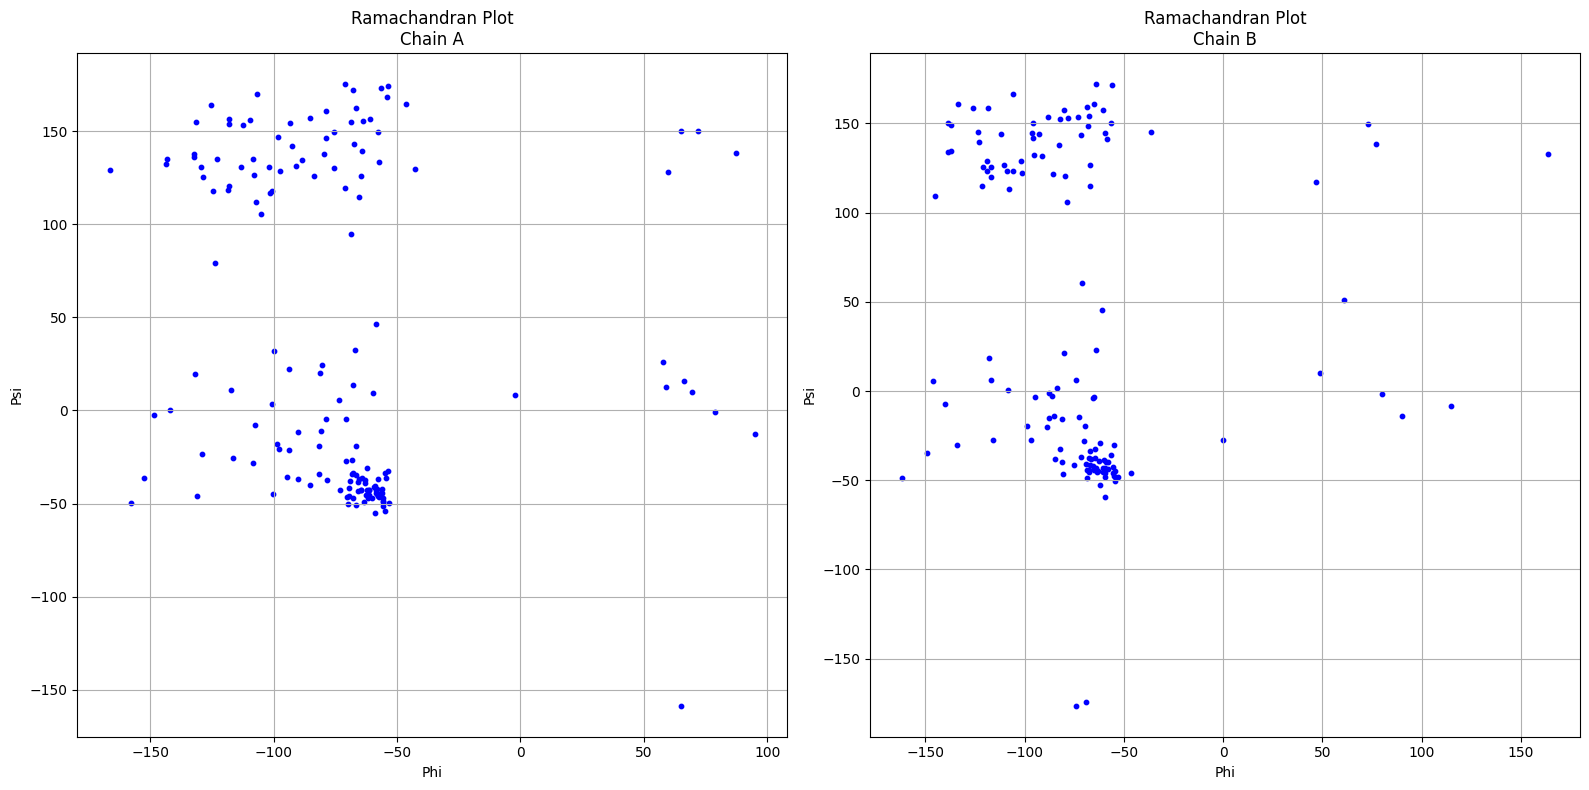

In [4]:
def plot_ramachandran(phi_psi_angles):
    """Create a Ramachandran plot with one subplot per chain."""
    num_chains = len(phi_psi_angles)
    if num_chains == 0:
        print("No chains to plot.")
        return

    fig, axes = plt.subplots(1, num_chains, figsize=(8 * num_chains, 8), squeeze=False)

    for idx, (chain_id, angles) in enumerate(phi_psi_angles.items()):
        ax = axes[0][idx]
        phi = [angle[0] for angle in angles if angle[0] is not None]
        psi = [angle[1] for angle in angles if angle[1] is not None]
        ax.scatter(phi, psi, color='b', s=10)
        ax.set_xlabel("Phi")
        ax.set_ylabel("Psi")
        ax.set_title(f"Ramachandran Plot\nChain {chain_id}")
        ax.grid(True)

        # Save each chain's plot
        fig_single, ax_single = plt.subplots(figsize=(8, 8))
        ax_single.scatter(phi, psi, color='b', s=10)
        ax_single.set_xlabel("Phi")
        ax_single.set_ylabel("Psi")
        ax_single.set_title(f"Ramachandran Plot\nChain {chain_id}")
        ax_single.grid(True)
        fig_single.tight_layout()
        fig_single.savefig(f"images/ramachandran_plot_chain_{chain_id}.png")
        plt.close(fig_single)

    fig.tight_layout()
    plt.show()

plot_ramachandran(phi_psi_degrees)

Draw a figure with only alpha carbons displayed using Pymol. Label the secondary structures and active site.

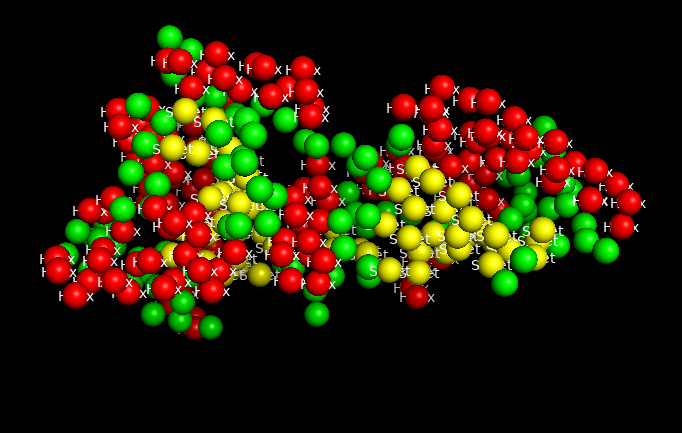

In [5]:
from IPython.display import Image, display

img_path = f"images/partA_5.png"
display(Image(filename=img_path))
